In [2]:
# Make sure that you have all these libaries available to run the code successfully
#from pandas_datareader import data
#print("Importing...")
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dense, Dropout 
import time
import pickle
import requests
import json
from pandas.io.json import json_normalize
import pprint
import pandas as pd

In [3]:
def save_obj(obj, name ):
    with open('bin/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('bin/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
import numpy as np
import pandas as pd

def createDataframe(inFile, skip, dateField,priceField,separator):
    targetFile = open('datafile.csv','w') 
    file = open(inFile, 'r') 
    i=0
    for line in file: 
        i+=1
        if i>skip:
            targetFile.write(line)
    targetFile.close() 
    # Read in price field as string, and convert it later
    df = pd.read_csv('datafile.csv', sep=separator, converters={priceField: str})
    df = df.sort_values('Date', ascending=True).dropna()
    
    prices = df[[dateField,priceField]]
    # Replacing commas before typecasting 
    df[priceField].replace(',','.',inplace=True)
    # Typecasting
    df[priceField] = df[priceField].astype(float)
    # Renaming collumns
    df.rename(columns={dateField: 'Date', priceField:'Close'}, inplace=True)
    return df

#df = createDataframe('NOVO-B.CO.csv', 0,'Date','Close',',')

In [5]:

def createWindowedDataset(df, window_size, column='Close'):
    #from pandas import ordered_merge
    # Scale the data to be between 0 and 1
    # When scaling remember! You normalize both test and train data with respect to training data
    # Because you are not supposed to have access to test data
    print('Shape '+str(df.shape))
    # scale values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled=scaler.fit_transform(df[[column]])
    series=pd.DataFrame(scaled)
    
    # Creating windowed dataset
    #print('Shape '+str(series.shape))
    series_s = series.copy()
    for i in range(window_size):
        prev = series_s.shift(-(i+1))
        prev.name = str(i)
        series = pd.concat([series, prev],axis=1)
    series.dropna(axis=0, inplace=True)
    newDF = series
    newDF.dropna(axis=0, inplace=True)
    return newDF, scaler
#createWindowedDataset(df,25)


In [6]:
def getTrainNumberOfRows(fraction, series):
    nrow = round(fraction*series.shape[0])
    return nrow
#nrow = getTestNumberOfRows(0.8,ds)
#nrow

In [303]:
def buildModel(window_size):
    model = Sequential()
    #model.add(LSTM(input_shape=(window_size,1), output_dim=window_size, return_sequences = True))
    model.add(LSTM(return_sequences=True, input_shape=(window_size, 1), units=50))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation("relu"))
    model.compile(loss="mse",optimizer="adam")
    model.summary
    return model

In [8]:
def trainModel(nrow, model, train_data_predictors, train_data_target, test_data_predictors, test_data_target):   
    start = time.time()
    model.fit(train_data_predictors,train_data_target,batch_size=512,epochs=20,validation_split=0.1, verbose=0)
    print("> Compilation Time : ", time.time() - start)
    return model
#trainedModel = trainModel(nrow, model, ds)




In [9]:

def downloadSymbolHistory(symbol, maxDate='2999-12-31', mode='persisted'):
    # Downloads historik data for symbol.
    # Filters rows newer than maxDate, so that historic data can be simmulated
    # and training the model as of any given historic date can be performed
    
    if mode.upper()!='DOWNLOAD':
        myDf=load_obj(symbol)
        print("Note: Loaded persisted time series data")
        return myDf[myDf.index<=maxDate]#.tail(1000)
    url = "https://www.alphavantage.co/query"
    function = "TIME_SERIES_DAILY"
    #symbol = "MSFT"
    api_key = "JS1OH18PC49XLGCG"   
    datatype = "json"
    outputsize = "full"

    data = { "function"   : function, 
             "symbol"     : symbol, 
             "apikey"     : api_key ,
             "datatype"   : datatype,
             "outputsize" : 'full'} 
    print("Note: Downloading time series data from "+url)
    page = requests.get(url, params = data)
    response_data = page.json()
    #print(response_data)
    try:
        timeSeriesJson = (response_data["Time Series (Daily)"])
    except:
        print("Error - retrying every 30 secs...")
        for i in range(1,5):
            try:
                time.sleep(30)
                print("Retrying...")
                page = requests.get(url, params = data)
                response_data = page.json()
                timeSeriesJson = (response_data["Time Series (Daily)"])
                print("Success")
                break
            except:
                pass
            if i == 5:
                print("Did not succeed after 5 retrys, exiting")
                exit(6)
        #print(timeSeriesJson)
    #print("Number of datarows downloaded: "+str(len(timeSeriesJson)))
    myDict = {}
    for key, value in timeSeriesJson.items():
        myDict[key] = value.get('4. close')
    myDf = pd.DataFrame.from_dict(myDict, orient='index')    
    myDf.columns = ['Close']
    myDf.index.name = 'Date'
    myDf.sort_index(inplace=True, ascending=True)
    df = pd.DataFrame()
    counter=0
    rel = []
    for index, row in myDf.iterrows():
        if counter==0:
            prev=float(row['Close'])
            #print(float(row['Close']))
        r=(float(row['Close'])-prev)/float(row['Close'])
        rel.append(r)
        counter+=1
        prev=float(row['Close'])
    #print(len(rel))
    se = pd.Series(rel)
    myDf['Relative'] = se.values
    save_obj(myDf,symbol)
    return myDf[myDf.index<=maxDate]#.tail(1000)
#downloadSymbolHistory('INTC', '2017-12-31', 'download')

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
def prepareAndTrain(symbol,df, maxDate='2999-12-31', window_size=50, column='Close',plot=True):
    alphaVantageAipKey='JS1OH18PC49XLGCG'
    #window_size=50
    #trainNRows = getTrainNumberOfRows(0.8,ds)
    #symbols = ['GOOGL']
    
    
    # Create the windowd dataframe
    series, scaler = createWindowedDataset(df,window_size, column)
    trainNrows = getTrainNumberOfRows(0.97,series)
    # Define the model
    model=buildModel(window_size)    
    # Create the train and test-dataset
    # Use the first
    print('trainNrows: '+str(trainNrows))
    #print('DS shape '+str(df.shape))
    train = series.iloc[:trainNrows, :]
    test = series.iloc[trainNrows:,:]
    # Now, shuffle the train-set
    from sklearn.utils import shuffle
    train = shuffle(train)
    # train_X is all rows, all columns minus last, which is the target variable
    train_X = train.iloc[:,:-1].values
    # train_y is all rows, last column only, which is the target variable
    train_y = train.iloc[:,-1].values
    test_X = test.iloc[:,:-1].values
    test_y = test.iloc[:,-1].values
    print('**')
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
    trainedModel = trainModel(trainNrows, model, train_X, train_y, test_X, test_y)
        
    from matplotlib import pyplot
    ac=np.asarray(test_y).reshape(-1,1)
    actuals = scaler.inverse_transform(ac)
    pd = trainedModel.predict(test_X)
    predicts=scaler.inverse_transform(pd)
    mape = mean_absolute_percentage_error(actuals,predicts)
    if plot==True:
        pyplot.plot(actuals)
        pyplot.plot(predicts)
        pyplot.show()
        import pandas as pd
        d = pd.DataFrame({'actuals':actuals.flatten('F'), 'predicts':predicts.flatten('F')})
        print("Mean Absolute Error: "+str(mean_absolute_error(actuals,predicts)))
        print("Mean Squared Error: "+str(mean_squared_error(actuals,predicts)))
        print("Mean Absolute Percentage Error: "+str(mape))
    #return df, trainedModel, scaler, mape
    return trainedModel, scaler, mape

#data, tm, sc = prepareAndTrain('GOOGL')


In [12]:
# Defining function to predict n future values.
# Returns list of n predictions as numpy array, and last prediction as float
#input = test_X[0]
nDays = 5
def predictNdays(nDays, trainedModel, scaler, inputSequence):
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [inputSequence]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(nDays):
        #print(i)
        preds_one_step = trainedModel.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    lastNDaysPredictions = moving_test_window[0][len(moving_test_window)-(nDays+2):]
    nthDayPrediction = lastNDaysPredictions[0].tolist()[0]
    lastDayPrediction = scaler.inverse_transform(nthDayPrediction)[0][0]
    return scaler.inverse_transform(lastNDaysPredictions), lastDayPrediction

#predictNdays(5, trainedModel, scaler, test_X[0])

Building the code that will run continously.
We´ll skip the test-part, because we´re now only predicting

In [13]:

def predict(symbol, window_size, predictDays, data, tm, sc, maxDate='2999-12-31', column='Close'):
    #data, tm, sc, mape = prepareAndTrain(symbol, maxDate, window_size,column, True)
    se,sc = createWindowedDataset(data,window_size, column)
    latestSequence=se[len(se)-1:].values
    latestSequence = latestSequence.reshape(latestSequence.shape[1],latestSequence.shape[0])[len(latestSequence):]
    nDays, nThDay = predictNdays(predictDays, tm, sc, latestSequence)
    sc.inverse_transform(latestSequence)
    nDays, nThDay
    return nDays, mape

In [14]:
# Gets the closing price for the following trading day
def getNextClose(symbol, date='2999-12-31', column='Close'):
    if date=='2999-12-31':
        print("Error: No date supplied - cannot get next closingprice")
    data = downloadSymbolHistory(symbol)
    data.insert(0, 'row_num', range(0,len(data)))  # here we insert the row count
    y = data.loc[date]['row_num']
    nextClose=data.loc[data['row_num'] == y+1]
    return pd.to_numeric(nextClose[column], errors='coerce').tolist()[0]
#getNextClose('NYSE:AXP', date='2017-12-12')
    

In [15]:
# Returns a list of valid tradingdays for the supplied symbol
def getTradingDays(symbol):
    data = downloadSymbolHistory(symbol)
    return data.index.tolist()
#getTradingDays('NYSE:AXP')

In [15]:
#getTradingDays('DWDP')
#getNextClose('DWDP', '2018-07-02')
#downloadSymbolHistory('DWDP')

Note: Downloading time series data from https://www.alphavantage.co/query
Note: Loaded persisted time series data
*****************************
Simmulating 21 days for MMM

09:08:09
***
Simmulating MMM at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  242.90749192237854


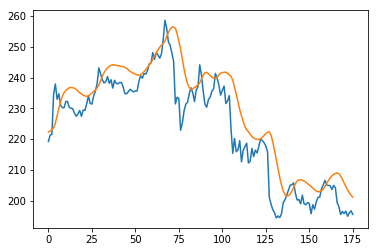

Mean Absolute Error: 6.30670451771
Mean Squared Error: 69.6806410312
Mean Absolute Percentage Error: 2.8848317363
Shape (5917, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.8848317363
Latest close     : 195.52
Next close       : 200.725073712 (2.66%)
4 Days close     : 201.767243235 (3.2%)
Actual next close: 195.83
Bying and selling - funds before: 10000
Bought and sold - funds now: 9986.8552

09:12:14
***
Simmulating MMM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.8848317363
Latest close     : 195.83
Next close       : 200.402064996 (2.33%)
4 Days close     : 201.589355032 (2.94%)
Actual next close: 197.34
Bying and selling - funds before: 9986.86
Bought and sold - funds now: 10034.8615

09:12:15
***
Simmulating MMM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MMM:
MAPE             :2.8

trainNrows: 5691
**
> Compilation Time :  246.8701400756836


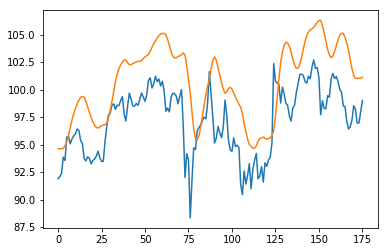

Mean Absolute Error: 3.64596342954
Mean Squared Error: 17.3918732691
Mean Absolute Percentage Error: 3.76523409132
Shape (5917, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             :3.76523409132
Latest close     : 99.0
Next close       : 101.398150557 (2.42%)
4 Days close     : 104.038337593 (5.09%)
Actual next close: 97.84
Bying and selling - funds before: 10671.16
Bought and sold - funds now: 10517.1218

09:16:34
***
Simmulating AXP at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             :3.76523409132
Latest close     : 97.84
Next close       : 101.616636413 (3.86%)
4 Days close     : 104.153013868 (6.45%)
Actual next close: 98.53
Bying and selling - funds before: 10517.12
Bought and sold - funds now: 10562.2921

09:16:34
***
Simmulating AXP at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
AXP:
MAPE             

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for AAPL

09:16:45
***
Simmulating AAPL at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  232.46089005470276


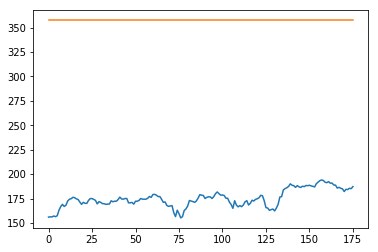

Mean Absolute Error: 182.538625377
Mean Squared Error: 33400.3370948
Mean Absolute Percentage Error: 104.853513732
Shape (5917, 2)
Note: Loaded persisted time series data
***
AAPL:
MAPE             :104.853513732
Latest close     : 187.18
Next close       : 357.52 (91.0%)
4 Days close     : 357.52 (91.0%)
Actual next close: 183.92
Bying and selling - funds before: 10117.76
Bought and sold - funds now: 9912.5439

09:20:39
***
Simmulating AAPL at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
AAPL:
MAPE             :104.853513732
Latest close     : 183.92
Next close       : 357.52 (94.39%)
4 Days close     : 357.52 (94.39%)
Actual next close: 185.4
Bying and selling - funds before: 9912.54
Bought and sold - funds now: 9963.3099

09:20:39
***
Simmulating AAPL at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
AAPL:
MAPE             :104.853513732
Lates

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for BA

09:20:49
***
Simmulating BA at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  232.557137966156


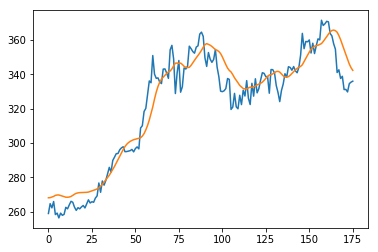

Mean Absolute Error: 7.68325997093
Mean Squared Error: 93.4657407394
Mean Absolute Percentage Error: 2.39589827634
Shape (5917, 2)
Note: Loaded persisted time series data
***
BA:
MAPE             :2.39589827634
Latest close     : 336.08
Next close       : 341.359744576 (1.57%)
4 Days close     : 341.565851284 (1.63%)
Actual next close: 332.93
Bying and selling - funds before: 10249.1
Bought and sold - funds now: 10124.0408

09:24:43
***
Simmulating BA at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
BA:
MAPE             :2.39589827634
Latest close     : 332.93
Next close       : 340.529514251 (2.28%)
4 Days close     : 340.962638838 (2.41%)
Actual next close: 333.18
Bying and selling - funds before: 10124.04
Bought and sold - funds now: 10102.6431

09:24:44
***
Simmulating BA at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
BA:
MAPE             :

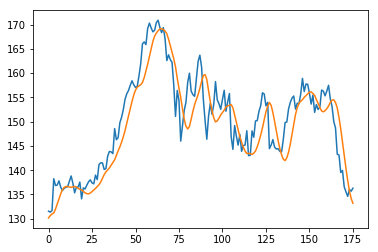

Mean Absolute Error: 3.5585890059
Mean Squared Error: 20.0899116755
Mean Absolute Percentage Error: 2.35938291685
Shape (5917, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :2.35938291685
Latest close     : 136.29
Next close       : 132.79124011 (-2.57%)
4 Days close     : 131.940587643 (-3.19%)
Actual next close: 133.83

09:29:25
***
Simmulating CAT at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :2.35938291685
Latest close     : 133.83
Next close       : 132.59165365 (-0.93%)
4 Days close     : 131.957817826 (-1.4%)
Actual next close: 135.81

09:29:26
***
Simmulating CAT at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
CAT:
MAPE             :2.35938291685
Latest close     : 135.81
Next close       : 132.733171624 (-2.27%)
4 Days close     : 132.605615084 (-2.36%)
Actual next close: 135.41

09:29:26


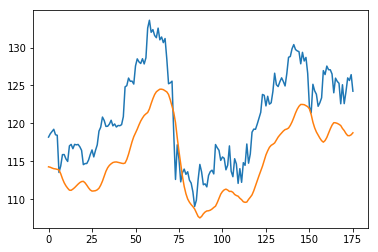

Mean Absolute Error: 5.6239417683
Mean Squared Error: 37.2889024756
Mean Absolute Percentage Error: 4.59521497359
Shape (5917, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :4.59521497359
Latest close     : 124.25
Next close       : 118.890931285 (-4.31%)
4 Days close     : 116.635748034 (-6.13%)
Actual next close: 124.73

09:33:36
***
Simmulating CVX at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :4.59521497359
Latest close     : 124.73
Next close       : 118.949587024 (-4.63%)
4 Days close     : 116.603935398 (-6.51%)
Actual next close: 123.98

09:33:36
***
Simmulating CVX at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
CVX:
MAPE             :4.59521497359
Latest close     : 123.98
Next close       : 118.892964895 (-4.1%)
4 Days close     : 116.416279016 (-6.1%)
Actual next close: 124.14

09:33:36

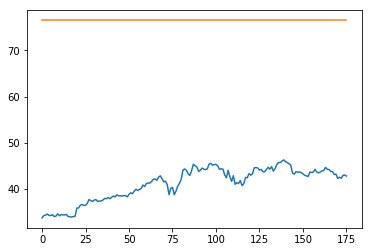

Mean Absolute Error: 35.3628977273
Mean Squared Error: 1263.07149716
Mean Absolute Percentage Error: 87.4479919232
Shape (5917, 2)
Note: Loaded persisted time series data
***
CSCO:
MAPE             :87.4479919232
Latest close     : 42.81
Next close       : 76.5 (78.7%)
4 Days close     : 76.5 (78.7%)
Actual next close: 42.67
Bying and selling - funds before: 10500.29
Bought and sold - funds now: 10436.9506

09:37:42
***
Simmulating CSCO at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
CSCO:
MAPE             :87.4479919232
Latest close     : 42.67
Next close       : 76.5 (79.28%)
4 Days close     : 76.5 (79.28%)
Actual next close: 42.56
Bying and selling - funds before: 10436.95
Bought and sold - funds now: 10381.0449

09:37:43
***
Simmulating CSCO at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
CSCO:
MAPE             :87.4479919232
Latest close 

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for KO

09:37:52
***
Simmulating KO at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  235.29971885681152


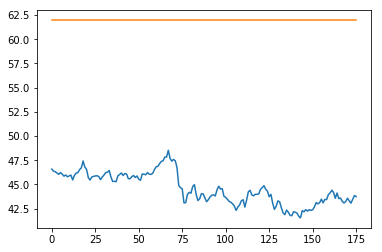

Mean Absolute Error: 17.3630700129
Mean Squared Error: 304.051876085
Mean Absolute Percentage Error: 39.1172337464
Shape (5917, 2)
Note: Loaded persisted time series data
***
KO:
MAPE             :39.1172337464
Latest close     : 43.75
Next close       : 61.955 (41.61%)
4 Days close     : 61.955 (41.61%)
Actual next close: 43.99
Bying and selling - funds before: 9667.64
Bought and sold - funds now: 9691.672

09:41:49
***
Simmulating KO at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
KO:
MAPE             :39.1172337464
Latest close     : 43.99
Next close       : 61.955 (40.84%)
4 Days close     : 61.955 (40.84%)
Actual next close: 44.66
Bying and selling - funds before: 9691.67
Bought and sold - funds now: 9810.2833

09:41:49
***
Simmulating KO at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
KO:
MAPE             :39.1172337464
Latest close     :

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for DIS

09:41:58
***
Simmulating DIS at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  235.69746804237366


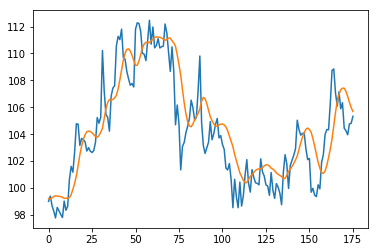

Mean Absolute Error: 1.64843907963
Mean Squared Error: 4.38212600299
Mean Absolute Percentage Error: 1.58279715888
Shape (5917, 2)
Note: Loaded persisted time series data
***
DIS:
MAPE             :1.58279715888
Latest close     : 105.33
Next close       : 105.535359279 (0.19%)
4 Days close     : 105.614041454 (0.27%)
Actual next close: 104.04

09:45:56
***
Simmulating DIS at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
DIS:
MAPE             :1.58279715888
Latest close     : 104.04
Next close       : 105.369449862 (1.28%)
4 Days close     : 105.429008648 (1.34%)
Actual next close: 105.34
Bying and selling - funds before: 9626.57
Bought and sold - funds now: 9717.86

09:45:56
***
Simmulating DIS at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
DIS:
MAPE             :1.58279715888
Latest close     : 105.34
Next close       : 105.320293768 (-0.02%)

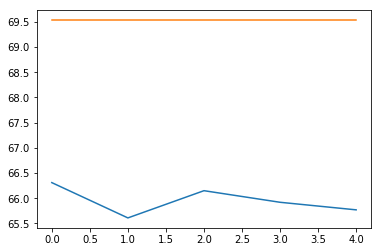

Mean Absolute Error: 3.5779987793
Mean Squared Error: 12.8657712646
Mean Absolute Percentage Error: 5.42669915227
Shape (213, 2)
Note: Loaded persisted time series data
***
DWDP:
MAPE             :5.42669915227
Latest close     : 65.77
Next close       : 69.53 (5.72%)
4 Days close     : 69.53 (5.72%)
Actual next close: 65.15
Bying and selling - funds before: 9717.86
Bought and sold - funds now: 9597.2518

09:46:15
***
Simmulating DWDP at date: 2018-07-03
Note: Loaded persisted time series data
Shape (214, 2)
Note: Loaded persisted time series data
***
DWDP:
MAPE             :5.42669915227
Latest close     : 65.15
Next close       : 69.53 (6.72%)
4 Days close     : 69.53 (6.72%)
Actual next close: 66.07
Bying and selling - funds before: 9597.25
Bought and sold - funds now: 9703.7771

09:46:15
***
Simmulating DWDP at date: 2018-07-05
Note: Loaded persisted time series data
Shape (215, 2)
Note: Loaded persisted time series data
***
DWDP:
MAPE             :5.42669915227
Latest close     : 

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for XOM

09:46:22
***
Simmulating XOM at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  237.48434591293335


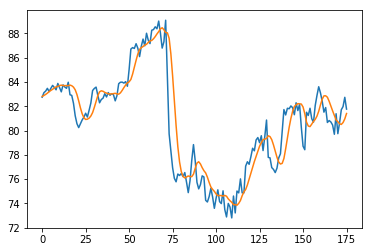

Mean Absolute Error: 1.14139092532
Mean Squared Error: 2.9127406672
Mean Absolute Percentage Error: 1.43333209336
Shape (5917, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.43333209336
Latest close     : 81.76
Next close       : 81.7475012553 (-0.02%)
4 Days close     : 82.2463830632 (0.59%)
Actual next close: 82.24

09:50:22
***
Simmulating XOM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.43333209336
Latest close     : 82.24
Next close       : 82.043731114 (-0.24%)
4 Days close     : 82.4620370519 (0.27%)
Actual next close: 82.31

09:50:22
***
Simmulating XOM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
XOM:
MAPE             :1.43333209336
Latest close     : 82.31
Next close       : 82.2733595547 (-0.04%)
4 Days close     : 82.604104754 (0.36%)
Actual next close: 82.33

09:50:22
***
Simm

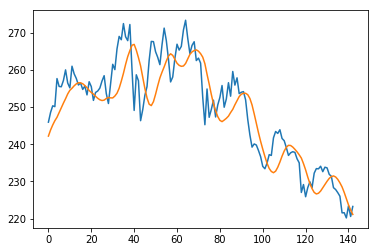

Mean Absolute Error: 5.23905358801
Mean Squared Error: 42.8889818691
Mean Absolute Percentage Error: 2.0828001744
Shape (4823, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.0828001744
Latest close     : 223.26
Next close       : 220.3423458 (-1.31%)
4 Days close     : 218.765411322 (-2.01%)
Actual next close: 220.38

09:53:46
***
Simmulating GS at date: 2018-07-03
Note: Loaded persisted time series data
Shape (4824, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.0828001744
Latest close     : 220.38
Next close       : 219.733918209 (-0.29%)
4 Days close     : 218.34906077 (-0.92%)
Actual next close: 220.74

09:53:46
***
Simmulating GS at date: 2018-07-05
Note: Loaded persisted time series data
Shape (4825, 2)
Note: Loaded persisted time series data
***
GS:
MAPE             :2.0828001744
Latest close     : 220.74
Next close       : 219.302828534 (-0.65%)
4 Days close     : 218.157815034 (-1.17%)
Actual next close: 221.79

09:53:47
***
Simm

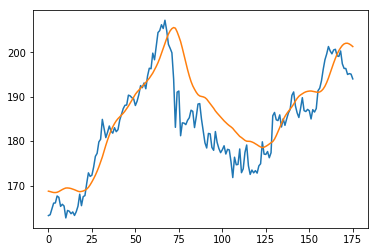

Mean Absolute Error: 4.53586490284
Mean Squared Error: 33.8802835381
Mean Absolute Percentage Error: 2.48507658351
Shape (5917, 2)
Note: Loaded persisted time series data
***
HD:
MAPE             :2.48507658351
Latest close     : 194.02
Next close       : 200.917743162 (3.56%)
4 Days close     : 200.843042431 (3.52%)
Actual next close: 193.62
Bying and selling - funds before: 9045.49
Bought and sold - funds now: 8997.8386

09:57:56
***
Simmulating HD at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
HD:
MAPE             :2.48507658351
Latest close     : 193.62
Next close       : 200.484584948 (3.55%)
4 Days close     : 200.356269553 (3.48%)
Actual next close: 194.41
Bying and selling - funds before: 8997.84
Bought and sold - funds now: 9005.5512

09:57:56
***
Simmulating HD at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
HD:
MAPE             :2.4

trainNrows: 5691
**
> Compilation Time :  249.42674684524536


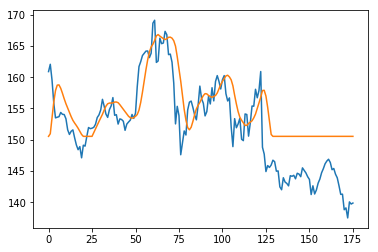

Mean Absolute Error: 4.16521304737
Mean Squared Error: 27.4204622437
Mean Absolute Percentage Error: 2.79897897368
Shape (5917, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :2.79897897368
Latest close     : 139.86
Next close       : 150.535 (7.63%)
4 Days close     : 150.535 (7.63%)
Actual next close: 139.57
Bying and selling - funds before: 8673.06
Bought and sold - funds now: 8626.0795

10:02:18
***
Simmulating IBM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :2.79897897368
Latest close     : 139.57
Next close       : 150.535 (7.86%)
4 Days close     : 150.535 (7.86%)
Actual next close: 141.43
Bying and selling - funds before: 8626.08
Bought and sold - funds now: 8712.0362

10:02:19
***
Simmulating IBM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
IBM:
MAPE             :2.79897897368
Latest c

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for INTC

10:02:29
***
Simmulating INTC at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  247.81842589378357


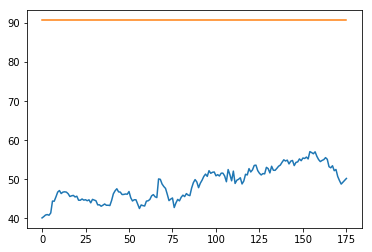

Mean Absolute Error: 41.976645591
Mean Squared Error: 1779.97246213
Mean Absolute Percentage Error: 87.4944968349
Shape (5917, 2)
Note: Loaded persisted time series data
***
INTC:
MAPE             :87.4944968349
Latest close     : 50.2
Next close       : 90.74 (80.76%)
4 Days close     : 90.74 (80.76%)
Actual next close: 49.47
Bying and selling - funds before: 8295.66
Bought and sold - funds now: 8146.0224

10:06:39
***
Simmulating INTC at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
INTC:
MAPE             :87.4944968349
Latest close     : 49.47
Next close       : 90.74 (83.42%)
4 Days close     : 90.74 (83.42%)
Actual next close: 50.75
Bying and selling - funds before: 8146.02
Bought and sold - funds now: 8327.7948

10:06:39
***
Simmulating INTC at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
INTC:
MAPE             :87.4944968349
Latest close 

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for JNJ

10:06:49
***
Simmulating JNJ at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  250.5274360179901


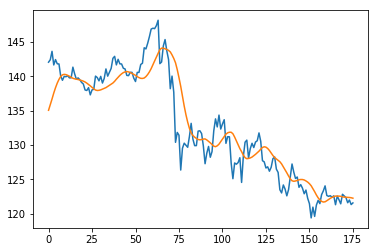

Mean Absolute Error: 2.14542098999
Mean Squared Error: 8.92406249642
Mean Absolute Percentage Error: 1.61286360036
Shape (5917, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.61286360036
Latest close     : 121.58
Next close       : 122.189155768 (0.5%)
4 Days close     : 122.083798437 (0.41%)
Actual next close: 122.71

10:11:02
***
Simmulating JNJ at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.61286360036
Latest close     : 122.71
Next close       : 122.156588759 (-0.45%)
4 Days close     : 122.14589781 (-0.46%)
Actual next close: 125.0

10:11:03
***
Simmulating JNJ at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
JNJ:
MAPE             :1.61286360036
Latest close     : 125.0
Next close       : 122.263894219 (-2.19%)
4 Days close     : 122.516590261 (-1.99%)
Actual next close: 125.75

10:11:03
**

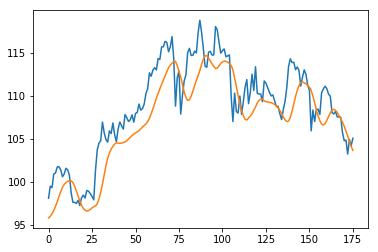

Mean Absolute Error: 2.39085176815
Mean Squared Error: 8.56663235493
Mean Absolute Percentage Error: 2.18597474782
Shape (5917, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :2.18597474782
Latest close     : 105.08
Next close       : 103.350524198 (-1.65%)
4 Days close     : 102.517309128 (-2.44%)
Actual next close: 103.61

10:15:27
***
Simmulating JPM at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :2.18597474782
Latest close     : 103.61
Next close       : 103.086067173 (-0.51%)
4 Days close     : 102.286874163 (-1.28%)
Actual next close: 103.72

10:15:27
***
Simmulating JPM at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
JPM:
MAPE             :2.18597474782
Latest close     : 103.72
Next close       : 102.870192929 (-0.82%)
4 Days close     : 102.128484184 (-1.53%)
Actual next close: 104.06

10:15

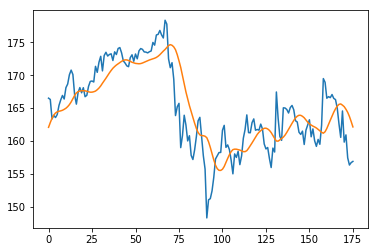

Mean Absolute Error: 2.88195748416
Mean Squared Error: 13.5938038793
Mean Absolute Percentage Error: 1.76294830204
Shape (5917, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             :1.76294830204
Latest close     : 156.87
Next close       : 161.301191554 (2.82%)
4 Days close     : 160.006263469 (2.0%)
Actual next close: 156.48
Bying and selling - funds before: 7483.12
Bought and sold - funds now: 7435.5148

10:19:53
***
Simmulating MCD at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             :1.76294830204
Latest close     : 156.48
Next close       : 160.514154543 (2.58%)
4 Days close     : 159.321205347 (1.82%)
Actual next close: 157.32
Bying and selling - funds before: 7435.51
Bought and sold - funds now: 7446.4294

10:19:53
***
Simmulating MCD at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MCD:
MAPE             

trainNrows: 5691
**
> Compilation Time :  251.19395089149475


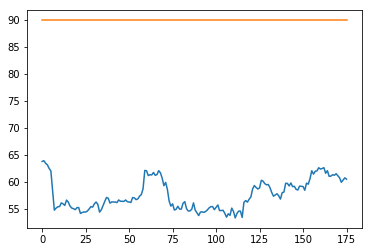

Mean Absolute Error: 32.4179542403
Mean Squared Error: 1058.54032908
Mean Absolute Percentage Error: 56.705550073
Shape (5917, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :56.705550073
Latest close     : 60.46
Next close       : 89.945 (48.77%)
4 Days close     : 89.945 (48.77%)
Actual next close: 60.71
Bying and selling - funds before: 7487.31
Bought and sold - funds now: 7489.2731

10:24:17
***
Simmulating MRK at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :56.705550073
Latest close     : 60.71
Next close       : 89.945 (48.16%)
4 Days close     : 89.945 (48.16%)
Actual next close: 61.64
Bying and selling - funds before: 7489.27
Bought and sold - funds now: 7574.9992

10:24:18
***
Simmulating MRK at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MRK:
MAPE             :56.705550073
Latest close    

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for MSFT

10:24:28
***
Simmulating MSFT at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  252.1390290260315


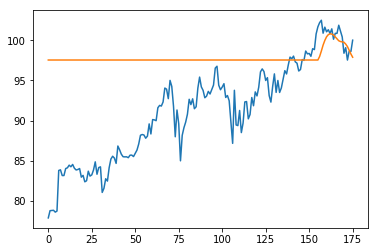

Mean Absolute Error: 6.94483769504
Mean Squared Error: 76.2442283209
Mean Absolute Percentage Error: 8.03365338786
Shape (5917, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :8.03365338786
Latest close     : 100.01
Next close       : 97.6951362668 (-2.31%)
4 Days close     : 97.545 (-2.46%)
Actual next close: 99.05

10:28:43
***
Simmulating MSFT at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :8.03365338786
Latest close     : 99.05
Next close       : 97.6107284596 (-1.45%)
4 Days close     : 97.545 (-1.52%)
Actual next close: 99.76

10:28:43
***
Simmulating MSFT at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
MSFT:
MAPE             :8.03365338786
Latest close     : 99.76
Next close       : 97.6699984448 (-2.1%)
4 Days close     : 97.545 (-2.22%)
Actual next close: 101.16

10:28:43
***
Simmulating M

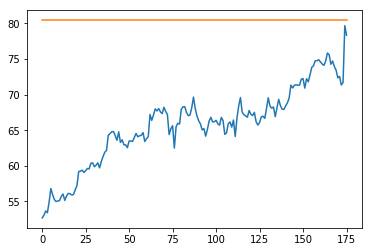

Mean Absolute Error: 14.7471332176
Mean Squared Error: 247.667196086
Mean Absolute Percentage Error: 23.3423309103
Shape (5917, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :23.3423309103
Latest close     : 78.35
Next close       : 80.445 (2.67%)
4 Days close     : 80.445 (2.67%)
Actual next close: 76.28
Bying and selling - funds before: 7483.75
Bought and sold - funds now: 7257.0338

10:33:10
***
Simmulating NKE at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :23.3423309103
Latest close     : 76.28
Next close       : 80.445 (5.46%)
4 Days close     : 80.445 (5.46%)
Actual next close: 76.55
Bying and selling - funds before: 7257.03
Bought and sold - funds now: 7253.7207

10:33:10
***
Simmulating NKE at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
NKE:
MAPE             :23.3423309103
Latest close    

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for PFE

10:33:21
***
Simmulating PFE at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  252.73380398750305


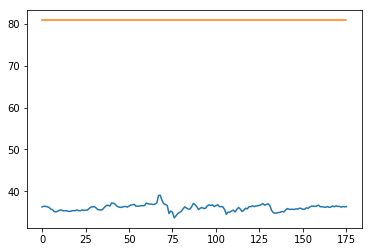

Mean Absolute Error: 44.8223912464
Mean Squared Error: 2009.59233886
Mean Absolute Percentage Error: 124.401480788
Shape (5917, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :124.401480788
Latest close     : 36.33
Next close       : 80.88 (122.63%)
4 Days close     : 80.88 (122.63%)
Actual next close: 36.35
Bying and selling - funds before: 6792.97
Bought and sold - funds now: 6767.7089

10:37:36
***
Simmulating PFE at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :124.401480788
Latest close     : 36.35
Next close       : 80.88 (122.5%)
4 Days close     : 80.88 (122.5%)
Actual next close: 36.87
Bying and selling - funds before: 6767.71
Bought and sold - funds now: 6835.5235

10:37:37
***
Simmulating PFE at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
PFE:
MAPE             :124.401480788
Latest close  

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for PG

10:37:48
***
Simmulating PG at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  252.32589888572693


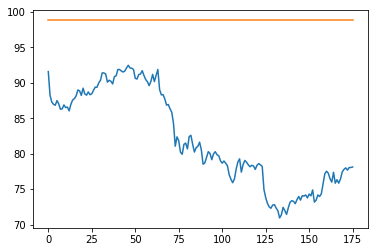

Mean Absolute Error: 16.7584054288
Mean Squared Error: 325.109124985
Mean Absolute Percentage Error: 21.2101626444
Shape (5917, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :21.2101626444
Latest close     : 78.13
Next close       : 98.84 (26.51%)
4 Days close     : 98.84 (26.51%)
Actual next close: 77.9
Bying and selling - funds before: 6879.71
Bought and sold - funds now: 6830.4581

10:42:03
***
Simmulating PG at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :21.2101626444
Latest close     : 77.9
Next close       : 98.84 (26.88%)
4 Days close     : 98.84 (26.88%)
Actual next close: 79.21
Bying and selling - funds before: 6830.46
Bought and sold - funds now: 6916.322

10:42:04
***
Simmulating PG at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
PG:
MAPE             :21.2101626444
Latest close     : 79.21

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for TRV

10:42:15
***
Simmulating TRV at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  252.83504700660706


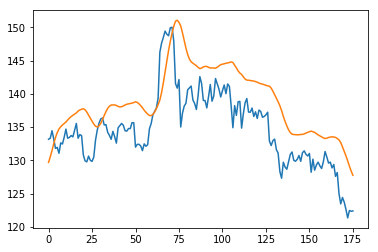

Mean Absolute Error: 4.63131600813
Mean Squared Error: 27.4397579056
Mean Absolute Percentage Error: 3.46144365438
Shape (5917, 2)
Note: Loaded persisted time series data
***
TRV:
MAPE             :3.46144365438
Latest close     : 122.39
Next close       : 127.226110451 (3.95%)
4 Days close     : 127.592830248 (4.25%)
Actual next close: 122.77
Bying and selling - funds before: 6483.0
Bought and sold - funds now: 6474.1291

10:46:31
***
Simmulating TRV at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
TRV:
MAPE             :3.46144365438
Latest close     : 122.77
Next close       : 126.822140001 (3.3%)
4 Days close     : 127.348774642 (3.73%)
Actual next close: 122.6
Bying and selling - funds before: 6474.13
Bought and sold - funds now: 6436.1643

10:46:31
***
Simmulating TRV at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
TRV:
MAPE             :3

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for UTX

10:46:41
***
Simmulating UTX at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (5917, 2)
trainNrows: 5691
**
> Compilation Time :  254.77483296394348


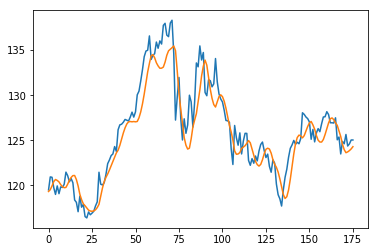

Mean Absolute Error: 1.58306628487
Mean Squared Error: 4.22027274134
Mean Absolute Percentage Error: 1.24199235996
Shape (5917, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.24199235996
Latest close     : 125.03
Next close       : 124.522576561 (-0.41%)
4 Days close     : 124.53463902 (-0.4%)
Actual next close: 124.92

10:50:59
***
Simmulating UTX at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.24199235996
Latest close     : 124.92
Next close       : 124.685918055 (-0.19%)
4 Days close     : 124.573976169 (-0.28%)
Actual next close: 124.95

10:50:59
***
Simmulating UTX at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
UTX:
MAPE             :1.24199235996
Latest close     : 124.95
Next close       : 124.770475259 (-0.14%)
4 Days close     : 124.541945157 (-0.33%)
Actual next close: 125.4

10:51:00

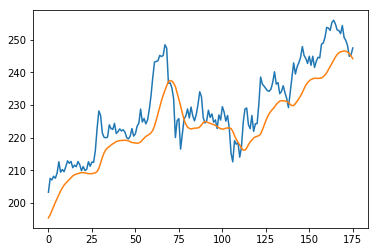

Mean Absolute Error: 6.32512054443
Mean Squared Error: 59.5623546911
Mean Absolute Percentage Error: 2.72583582844
Shape (5917, 2)
Note: Loaded persisted time series data
***
UNH:
MAPE             :2.72583582844
Latest close     : 247.48
Next close       : 243.520221968 (-1.6%)
4 Days close     : 241.024093409 (-2.61%)
Actual next close: 246.98

10:55:27
***
Simmulating UNH at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
UNH:
MAPE             :2.72583582844
Latest close     : 246.98
Next close       : 242.951916103 (-1.63%)
4 Days close     : 240.616469793 (-2.58%)
Actual next close: 250.5

10:55:27
***
Simmulating UNH at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
UNH:
MAPE             :2.72583582844
Latest close     : 250.5
Next close       : 242.717989321 (-3.11%)
4 Days close     : 240.781344995 (-3.88%)
Actual next close: 250.76

10:55:28

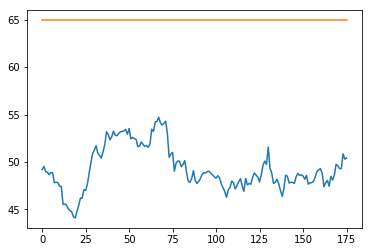

Mean Absolute Error: 15.6496019676
Mean Squared Error: 250.230679085
Mean Absolute Percentage Error: 32.0310207253
Shape (5917, 2)
Note: Loaded persisted time series data
***
VZ:
MAPE             :32.0310207253
Latest close     : 50.42
Next close       : 64.945 (28.81%)
4 Days close     : 64.945 (28.81%)
Actual next close: 50.7
Bying and selling - funds before: 6828.92
Bought and sold - funds now: 6837.8392

10:59:57
***
Simmulating VZ at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
VZ:
MAPE             :32.0310207253
Latest close     : 50.7
Next close       : 64.945 (28.1%)
4 Days close     : 64.945 (28.1%)
Actual next close: 51.28
Bying and selling - funds before: 6837.84
Bought and sold - funds now: 6887.063

10:59:57
***
Simmulating VZ at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
VZ:
MAPE             :32.0310207253
Latest close     : 51.

Note: Loaded persisted time series data
*****************************
Simmulating 21 days for V

11:00:06
***
Simmulating V at date: 2018-07-02
Note: Loaded persisted time series data
Training...
Shape (2591, 2)
trainNrows: 2465
**
> Compilation Time :  115.65731310844421


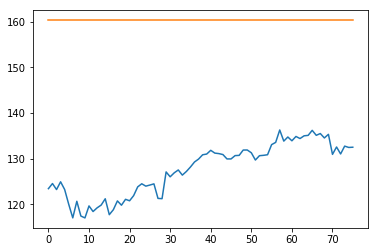

Mean Absolute Error: 32.7155373021
Mean Squared Error: 1102.94462806
Mean Absolute Percentage Error: 25.8873060232
Shape (2591, 2)
Note: Loaded persisted time series data
***
V:
MAPE             :25.8873060232
Latest close     : 132.5
Next close       : 160.355 (21.02%)
4 Days close     : 160.355 (21.02%)
Actual next close: 131.45
Bying and selling - funds before: 6392.18
Bought and sold - funds now: 6312.5239

11:02:04
***
Simmulating V at date: 2018-07-03
Note: Loaded persisted time series data
Shape (2592, 2)
Note: Loaded persisted time series data
***
V:
MAPE             :25.8873060232
Latest close     : 131.45
Next close       : 160.355 (21.99%)
4 Days close     : 160.355 (21.99%)
Actual next close: 133.29
Bying and selling - funds before: 6312.52
Bought and sold - funds now: 6371.8848

11:02:05
***
Simmulating V at date: 2018-07-05
Note: Loaded persisted time series data
Shape (2593, 2)
Note: Loaded persisted time series data
***
V:
MAPE             :25.8873060232
Latest close   

trainNrows: 5691
**
> Compilation Time :  256.3993010520935


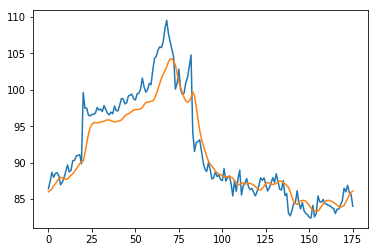

Mean Absolute Error: 1.71587405812
Mean Squared Error: 5.39748686941
Mean Absolute Percentage Error: 1.81038312928
Shape (5917, 2)
Note: Loaded persisted time series data
***
WMT:
MAPE             :1.81038312928
Latest close     : 84.0
Next close       : 85.8950704969 (2.26%)
4 Days close     : 85.6765146248 (2.0%)
Actual next close: 84.44
Bying and selling - funds before: 6060.88
Bought and sold - funds now: 6063.6291

11:06:33
***
Simmulating WMT at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
WMT:
MAPE             :1.81038312928
Latest close     : 84.44
Next close       : 85.5950976051 (1.37%)
4 Days close     : 85.3236194693 (1.05%)
Actual next close: 84.57
Bying and selling - funds before: 6063.63
Bought and sold - funds now: 6043.9644

11:06:33
***
Simmulating WMT at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
WMT:
MAPE             :1.81

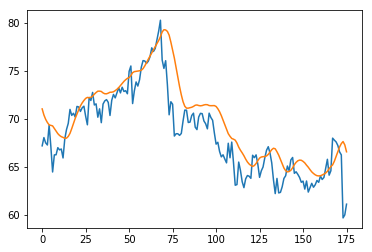

Mean Absolute Error: 1.86222407428
Mean Squared Error: 6.2954552133
Mean Absolute Percentage Error: 2.77134728488
Shape (5917, 2)
Note: Loaded persisted time series data
***
WBA:
MAPE             :2.77134728488
Latest close     : 61.13
Next close       : 65.7452630568 (7.55%)
4 Days close     : 64.9141728199 (6.19%)
Actual next close: 60.76
Bying and selling - funds before: 6082.67
Bought and sold - funds now: 6016.8558

11:11:01
***
Simmulating WBA at date: 2018-07-03
Note: Loaded persisted time series data
Shape (5918, 2)
Note: Loaded persisted time series data
***
WBA:
MAPE             :2.77134728488
Latest close     : 60.76
Next close       : 64.8823395312 (6.78%)
4 Days close     : 64.0615947205 (5.43%)
Actual next close: 62.38
Bying and selling - funds before: 6016.86
Bought and sold - funds now: 6148.2789

11:11:01
***
Simmulating WBA at date: 2018-07-05
Note: Loaded persisted time series data
Shape (5919, 2)
Note: Loaded persisted time series data
***
WBA:
MAPE             :2.7

In [304]:
#nDays, nThDay = predictNdays(nDays, tm, sc)
import time
#############################
# Setup                     #
#############################
sleepSecs = 600
results = {}
funds=10000
trainOnce=True
symbols = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DWDP','XOM','GS','HD','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
#symbols = ['BA']
column='Close'
window_size=50
symbolGains = {}

#############################
for symbol in symbols:
    downloadSymbolHistory(symbol,'2999-12-31','download')
    days = [days for days in getTradingDays(symbol) if days >= '2018-07-01' and days < '2018-08-01']
    print("*****************************")
    print("Simmulating "+str(len(days))+" days for "+symbol)
    #tradingDays=getTradingDays(symbol)
    dayNumber=0
    for day in days:
        startFunds=funds
        dayNumber+=1
        print("")
        print (time.strftime("%H:%M:%S"))
        print("***")
        print("Simmulating "+symbol+" at date: "+day)
        #break
        data=downloadSymbolHistory(symbol, day)
        if dayNumber==1:
            print("Training...")
            tm, sc, mape = prepareAndTrain(symbol, data, day, window_size,column, True)
        else:
            if trainOnce==False:
                print("Training...")
                tm, sc, mape = prepareAndTrain(symbol,data, day, window_size,column, True)
        nDays, mape = predict(symbol,window_size,5, data, tm, sc, day, column) #Close vs Relative
        latestClose=nDays[0][0]
        nextClose=nDays[1][0]
        fourDaysClose=nDays[4][0]
        actualNextClose=getNextClose(symbol, day, column)
        gainPct = round((nextClose-latestClose)/latestClose*100,2)    
        fourDaysGainPct = round((fourDaysClose-latestClose)/latestClose*100,2)        
        print("***")
        print(symbol+":")
        print("MAPE             :"+str(mape))        
        if column == 'Close':
            print("Latest close     : "+str(latestClose))
            print("Next close       : "+str(nextClose)+" ("+str(gainPct)+"%)")
            print("4 Days close     : "+str(fourDaysClose)+" ("+str(fourDaysGainPct)+"%)")
            print("Actual next close: "+str(actualNextClose))
            if gainPct>0.50:
                print("Bying and selling - funds before: "+str(round(funds,2)))
                funds=(funds/latestClose*actualNextClose)-29
                print("Bought and sold - funds now: "+str(round(funds,4)))
        if column == 'Relative':
            print("Latest close     : "+str(round(latestClose*100,4))+'%')
            print("Next close       : "+str(round(nextClose*100,4))+"%")
            print("4 Days close     : "+str(round(fourDaysClose*100,4))+"%")
            print("Actual next close: "+str(round(actualNextClose*100,4))+"%")
            if nextClose>0.005:
                print("Bying and selling - funds before: "+str(round(funds,2)))
                funds=(funds*(actualNextClose+1))-29
                print("Bought and sold - funds now: "+str(round(funds,2)))
        results[symbol]=[nDays,[mape]]
    print("Funds total: "+str(round(funds,2)))
    symbolGains[symbol]=str(round((funds-startFunds)/funds*100,4))+'%'
    print(symbolGains)
    
    #print("Sleeping before next symbol")
    #time.sleep(sleepSecs)
    
    
    

In [ ]:
for key, value in results.items():
    nDays=value[0]
    mape = value[1]
    #print(mape[0])
    print(key+":")
    print("Mean Percentage Absolute Error: "+str(round(mape[0],2))+"%")
    print("Latest close                  : "+str(nDays[0][0]))
    print("Next close                    : "+str(nDays[1][0])+" ("+str(round((nDays[1][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
    print("Close in "+str(len(nDays)-1)+" days               : "+str(nDays[5][0])+" ("+str(round((nDays[5][0]-nDays[0][0])/nDays[0][0]*100,2))+"%)")
    print('***')

## Doing classic SMA (Simple Moving Average) (shot/long) and looking for "golden cross" and "death cross"

Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for MMM


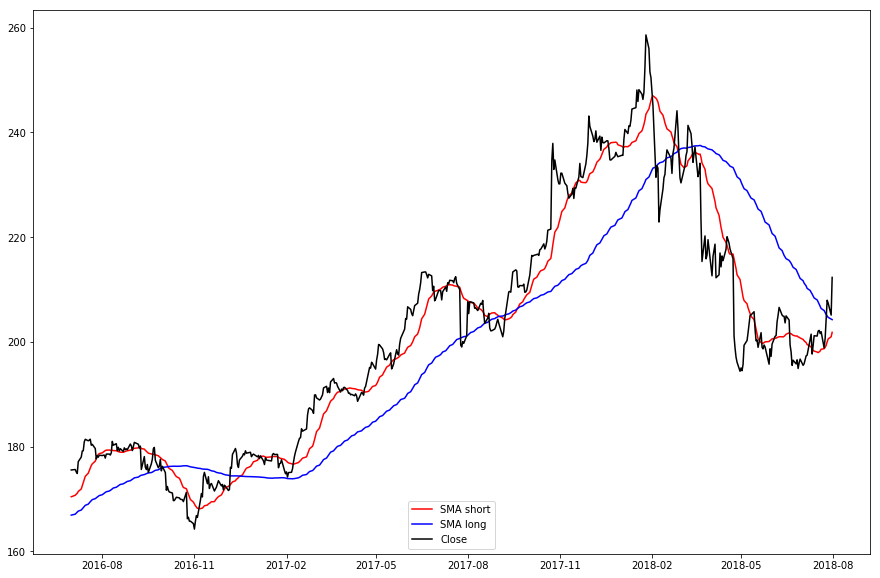

Done simmulating
23.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for AXP


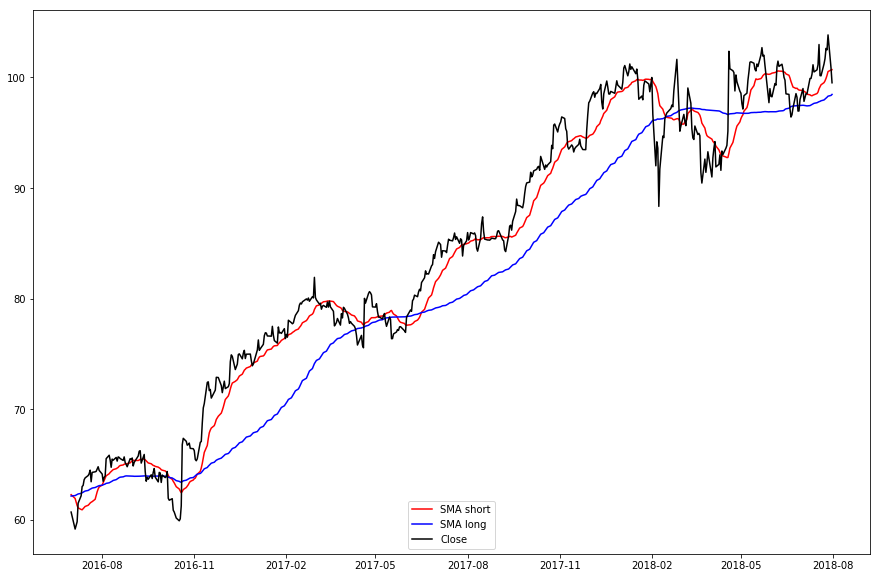

Done simmulating
30.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for AAPL


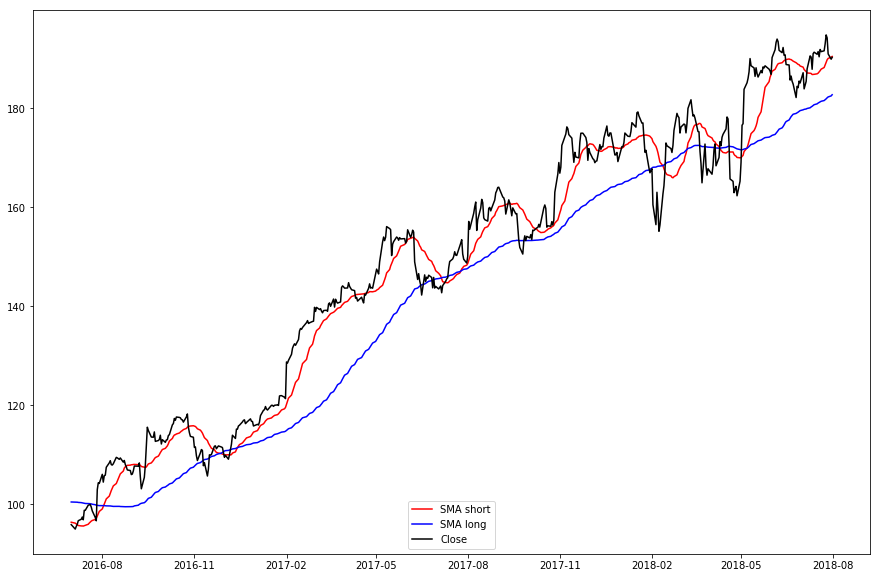

Done simmulating
37.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for BA


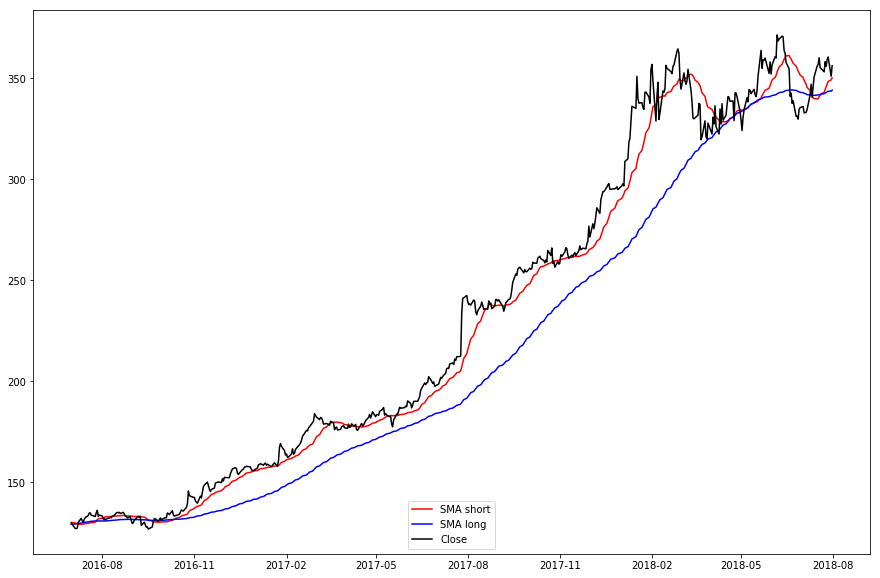

Done simmulating
104.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for CAT


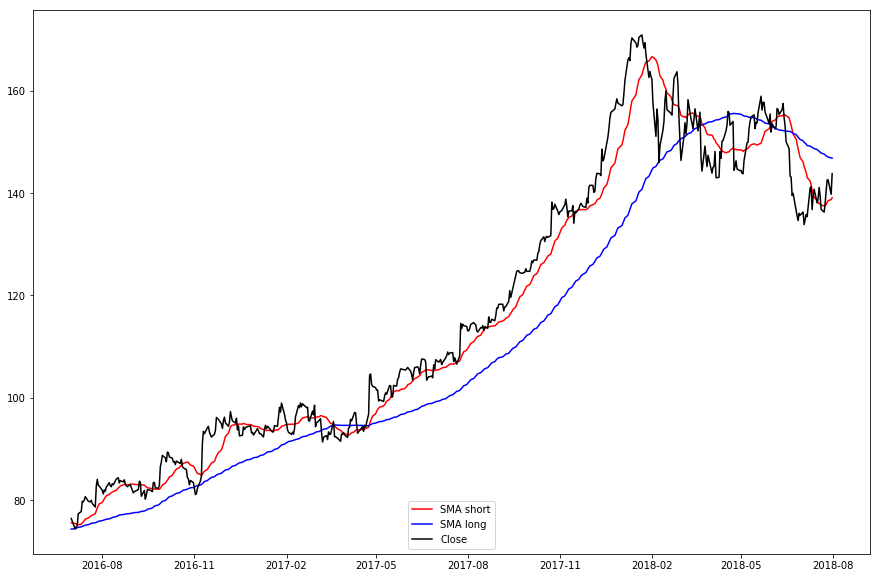

Done simmulating
33.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for CVX


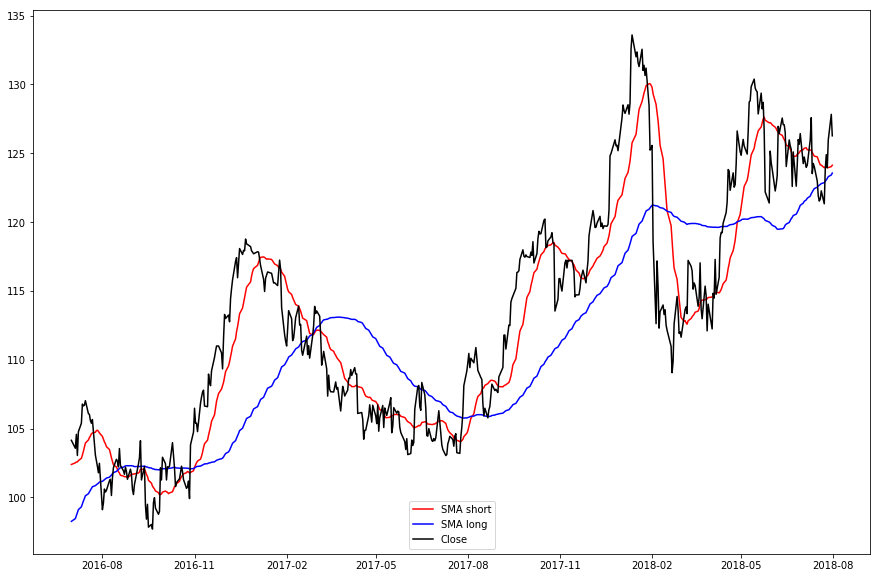

Done simmulating
9.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for CSCO


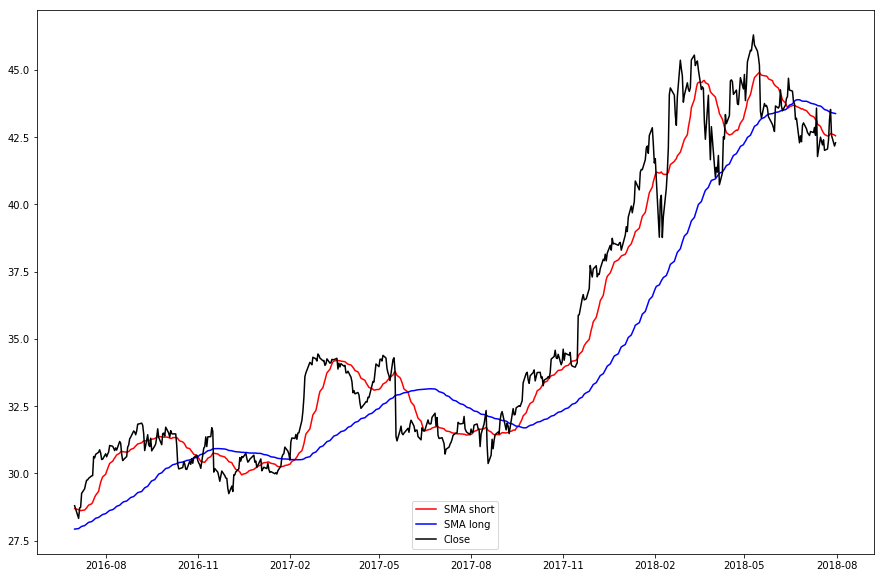

Done simmulating
19.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for KO


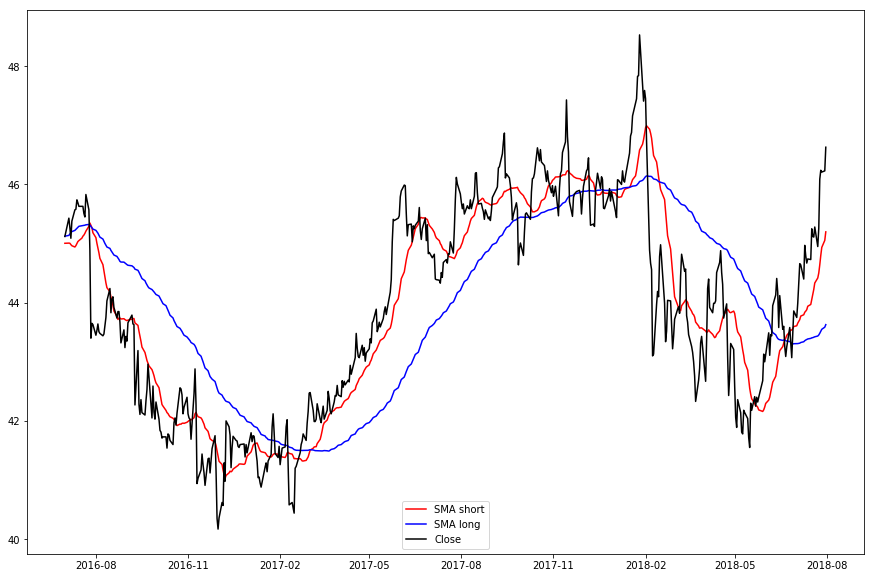

Done simmulating
9.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for DIS


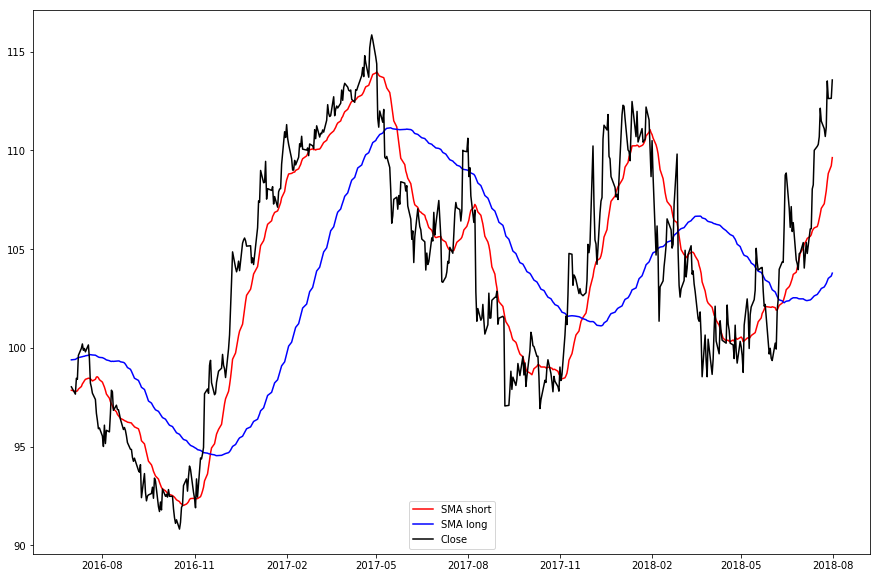

Done simmulating
20.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for XOM


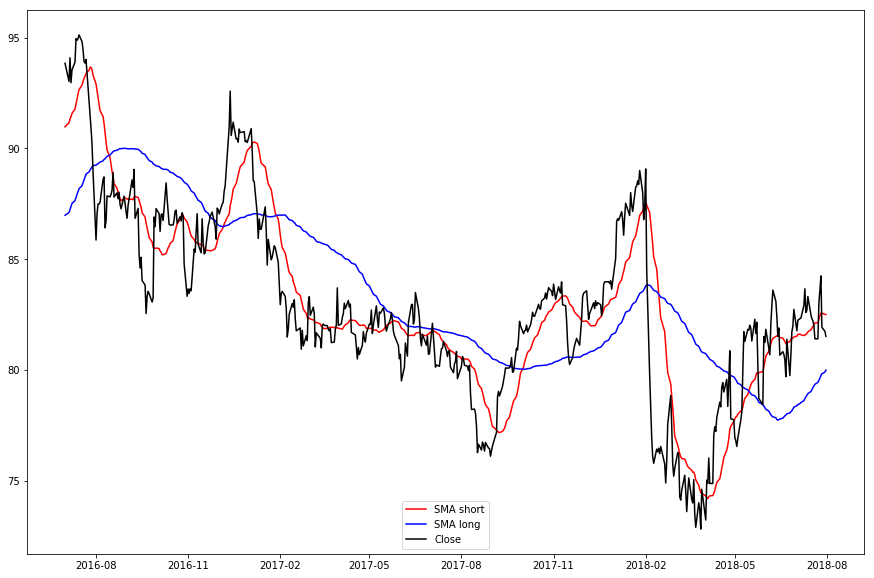

Done simmulating
-1.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for GS


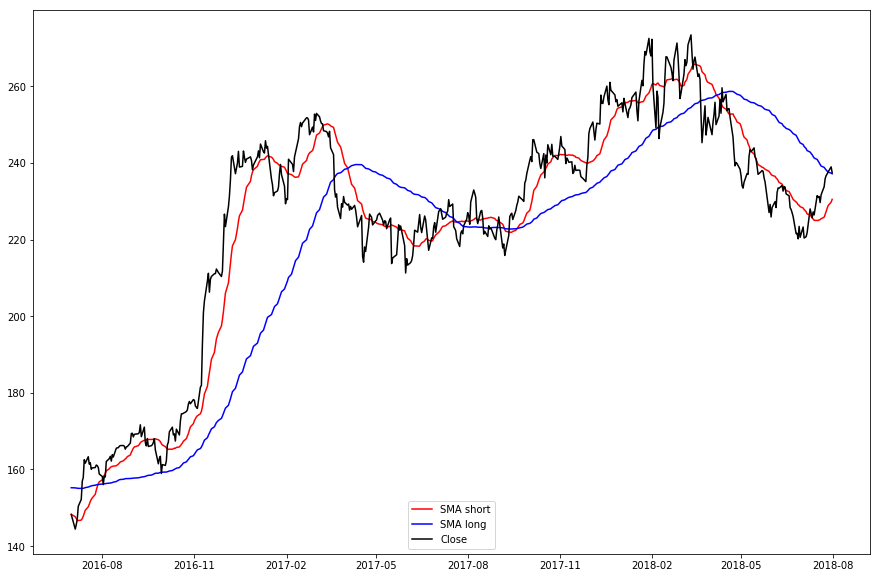

Done simmulating
58.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for HD


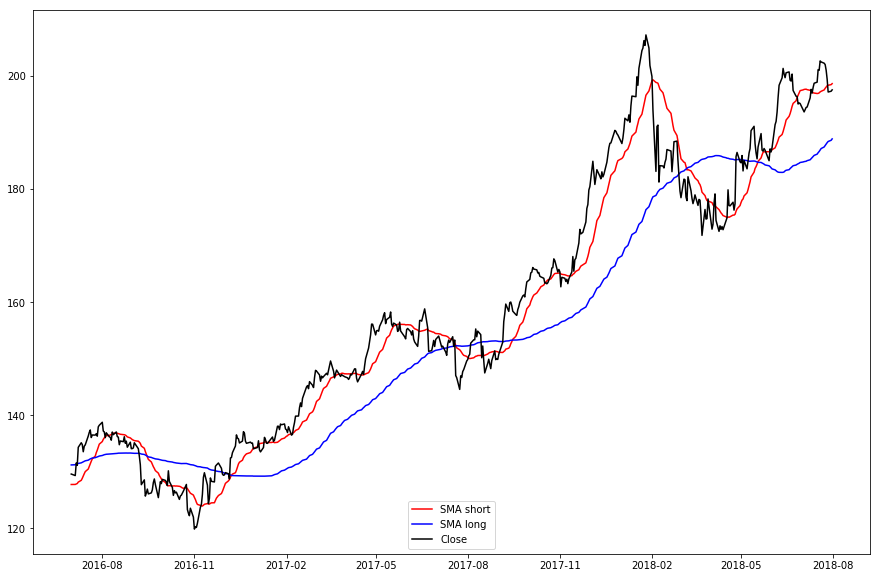

Done simmulating
26.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for IBM


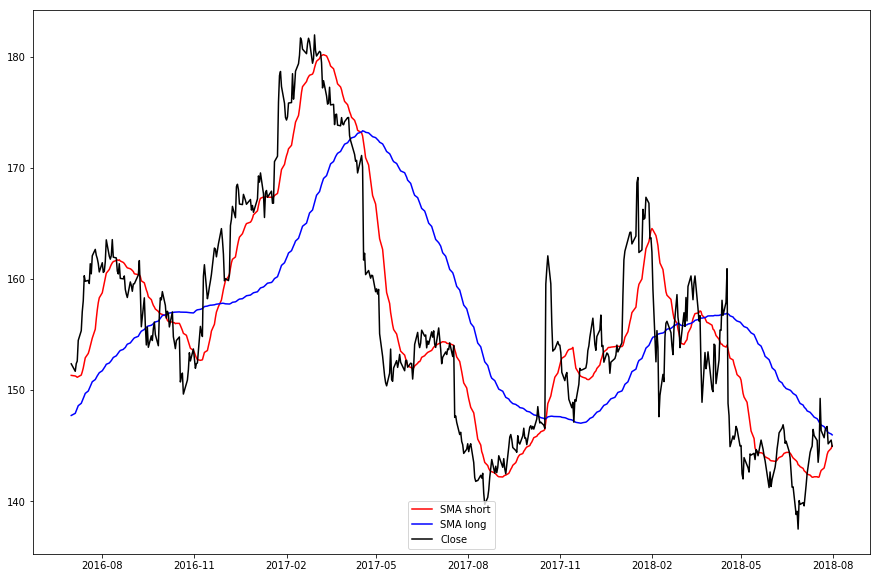

Done simmulating
-4.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for INTC


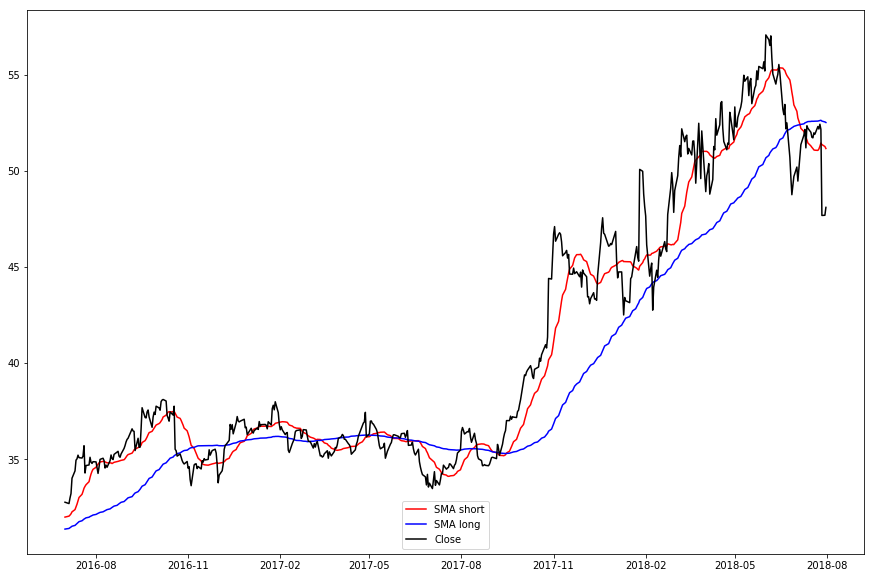

Done simmulating
4.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for JNJ


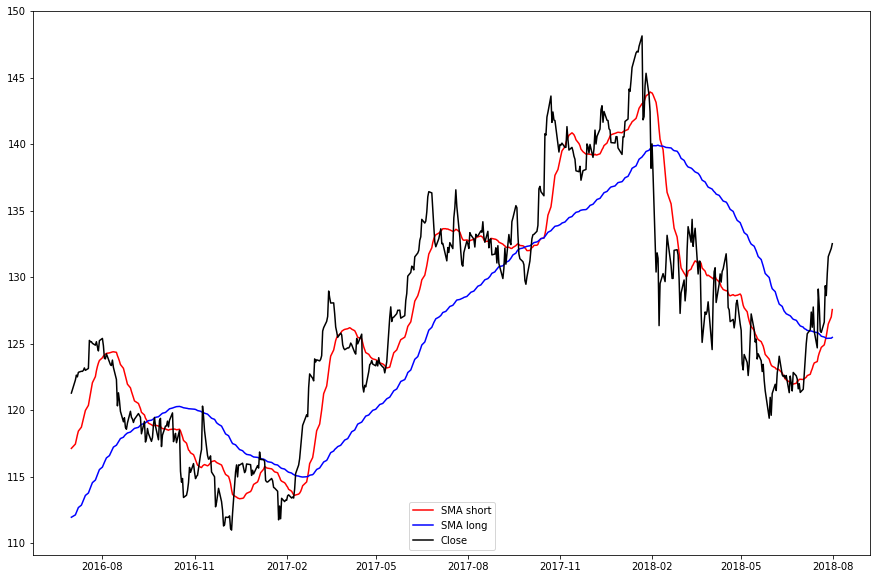

Done simmulating
10.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for JPM


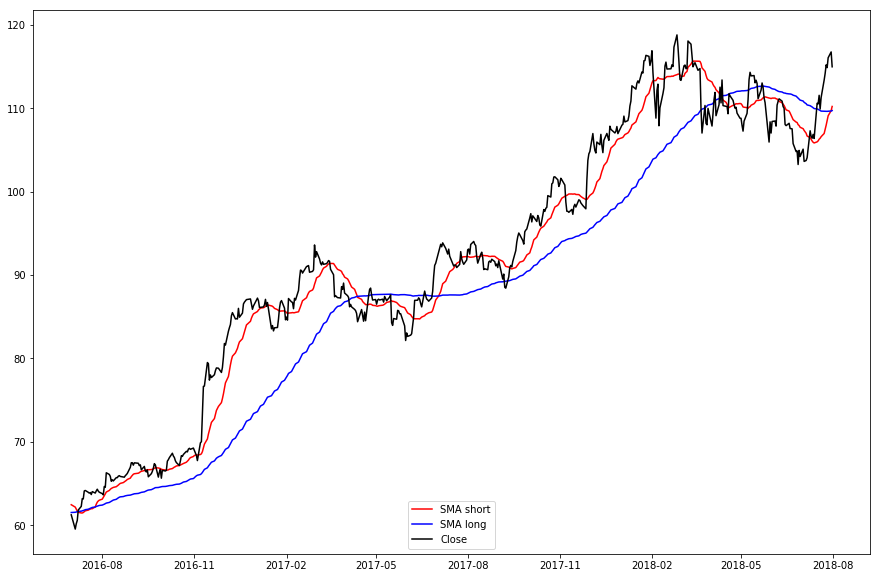

Done simmulating
52.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for MCD


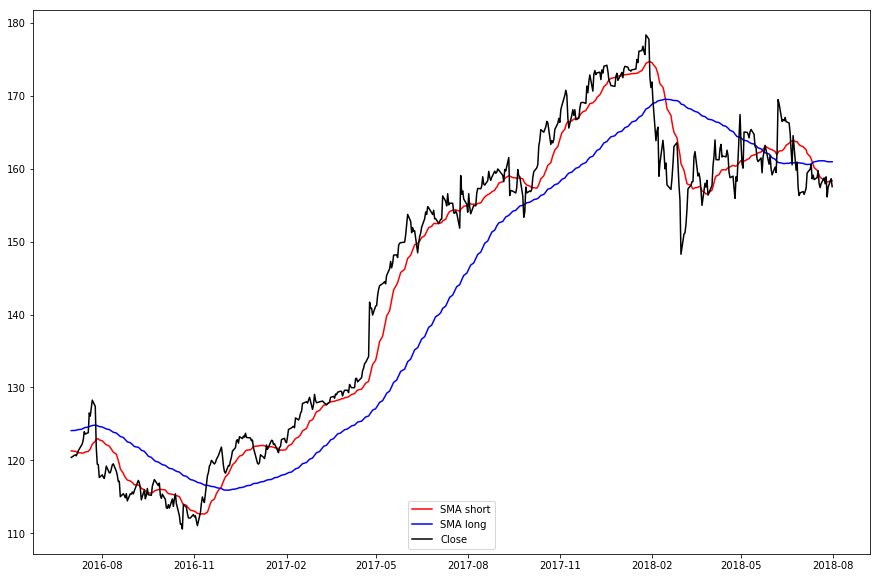

Done simmulating
28.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for MRK


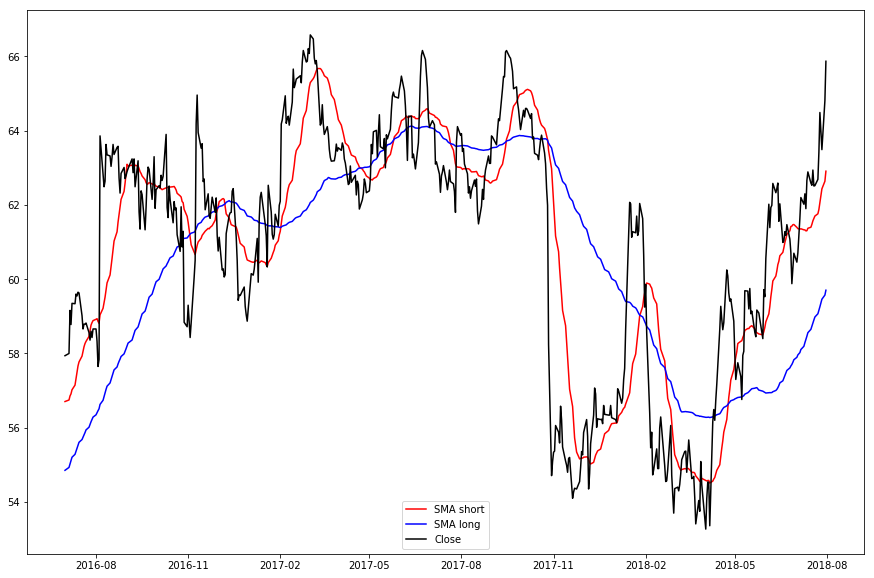

Done simmulating
-20.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for MSFT


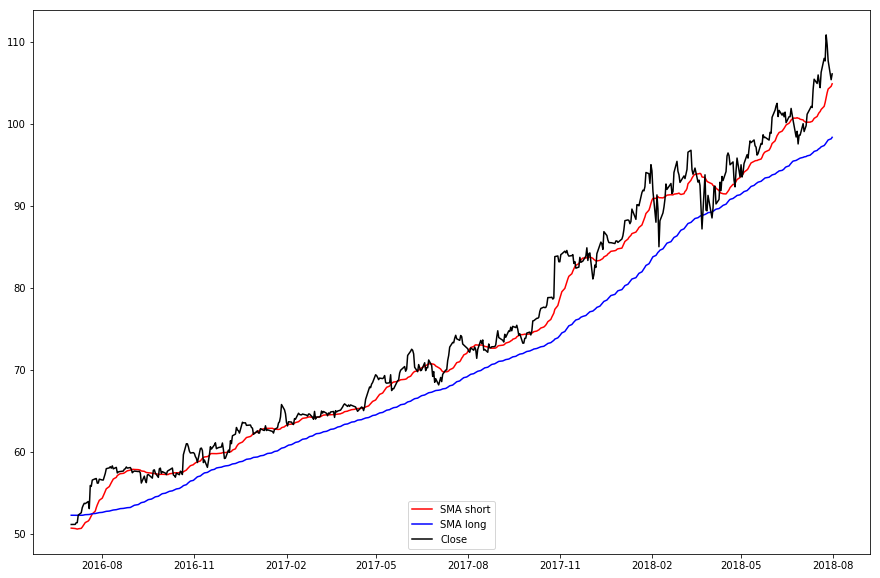

Done simmulating
55.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for NKE


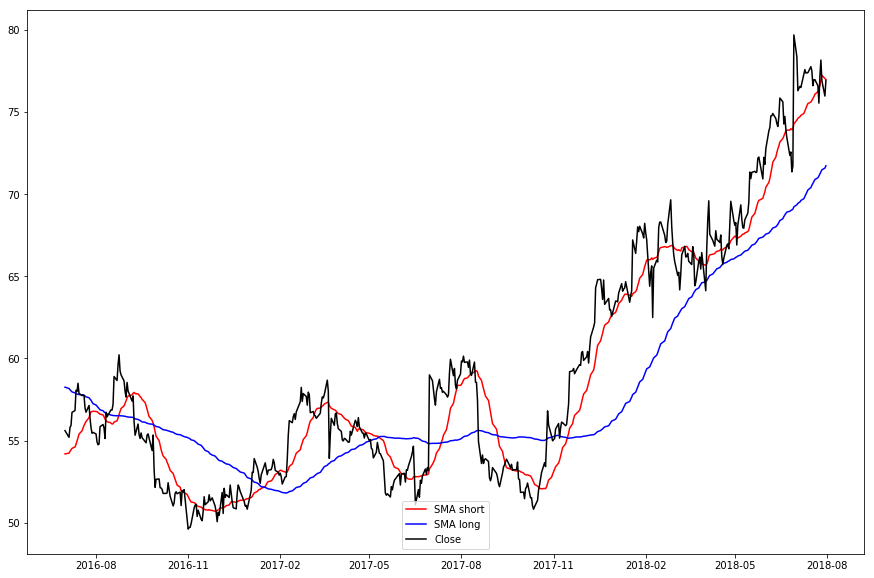

Done simmulating
-5.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for PFE


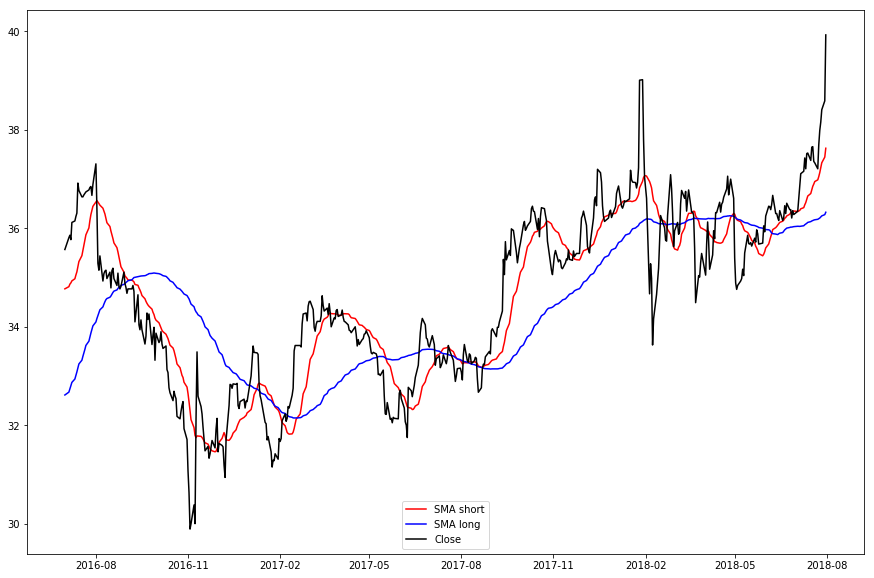

Done simmulating
-7.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for PG


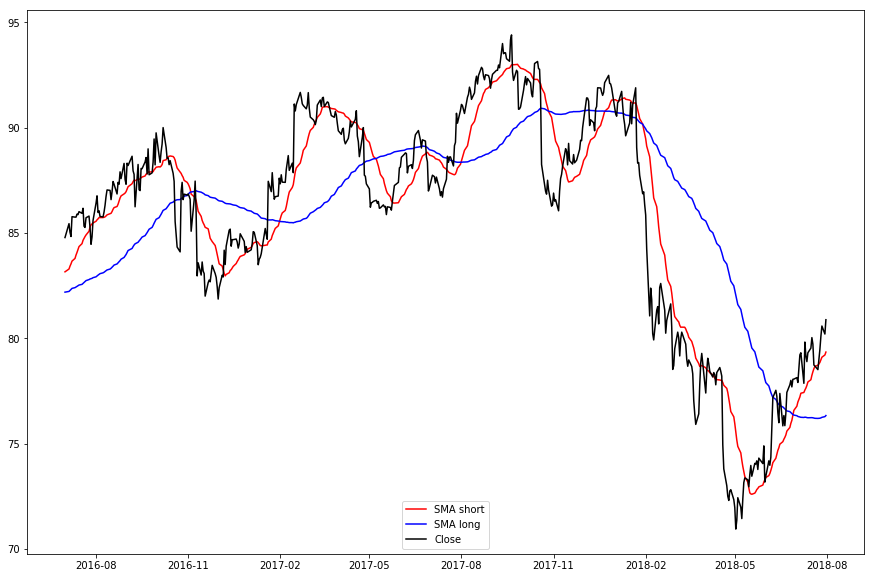

Done simmulating
-8.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for TRV


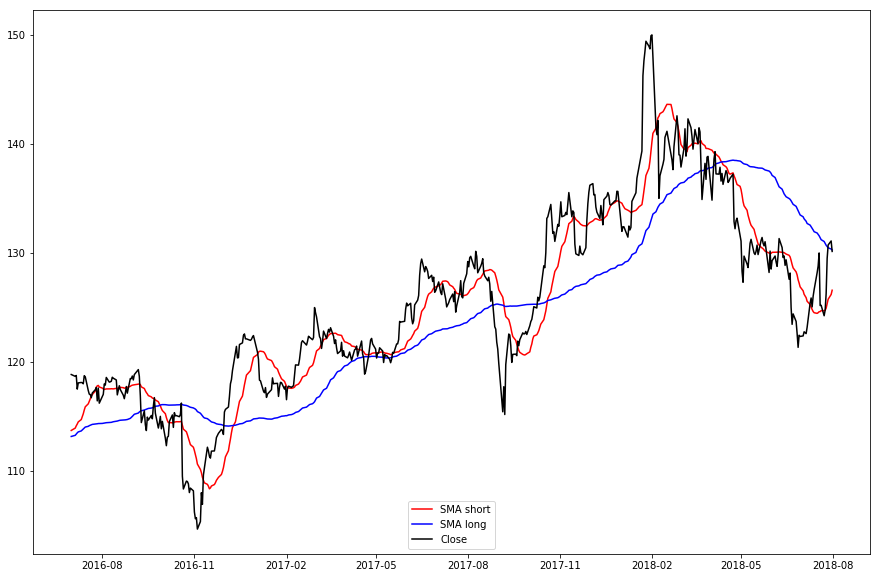

Done simmulating
1.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for UTX


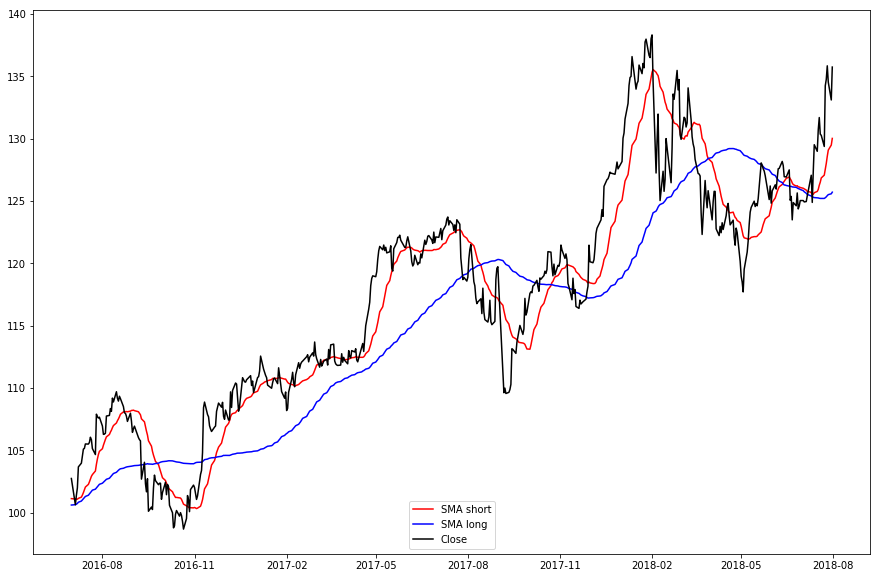

Done simmulating
22.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for UNH


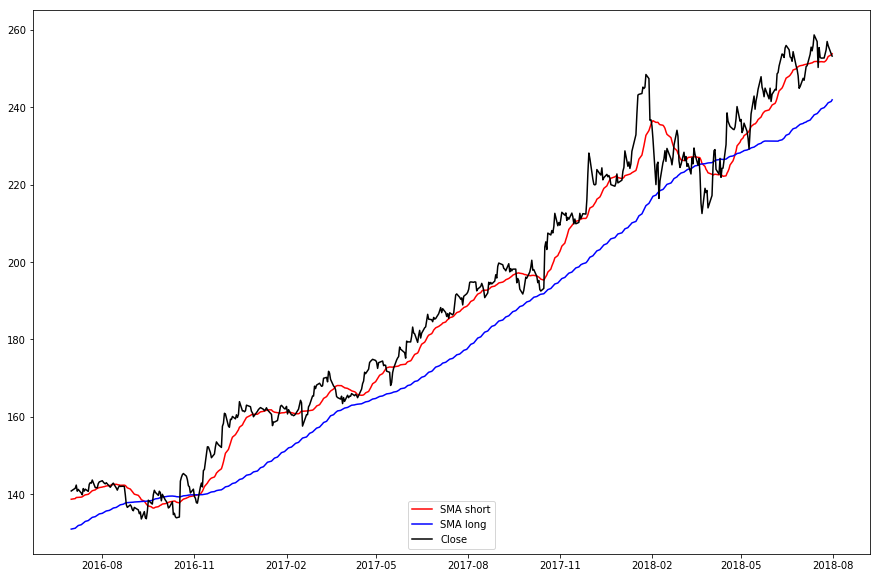

Done simmulating
79.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for VZ


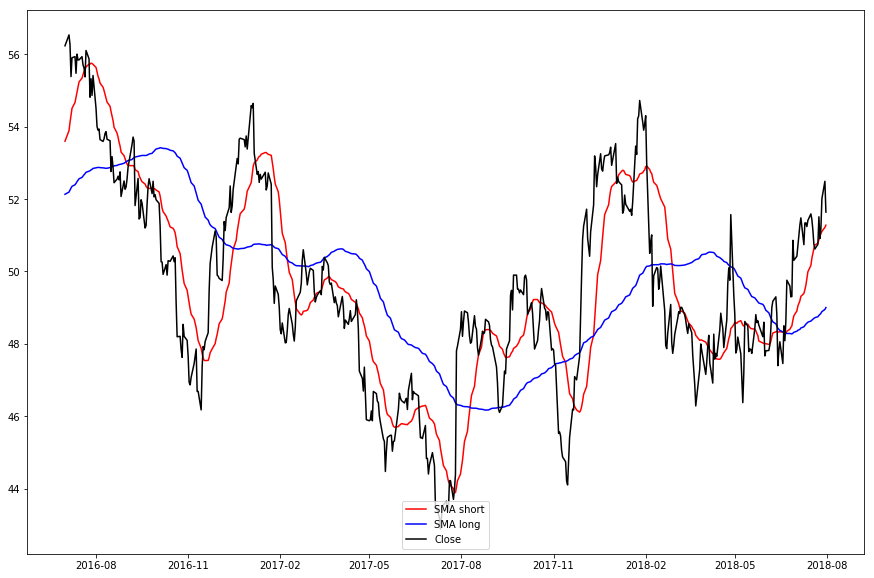

Done simmulating
-9.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for V


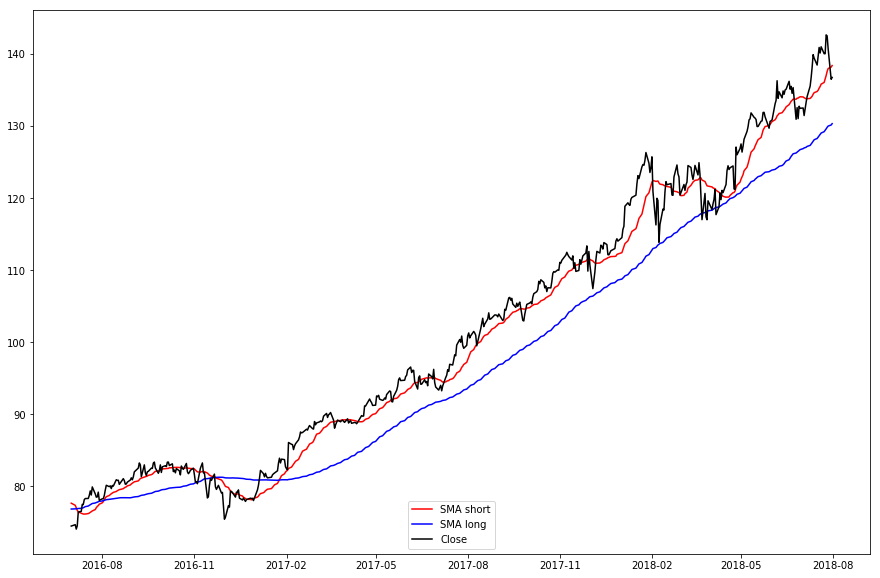

Done simmulating
35.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for WMT


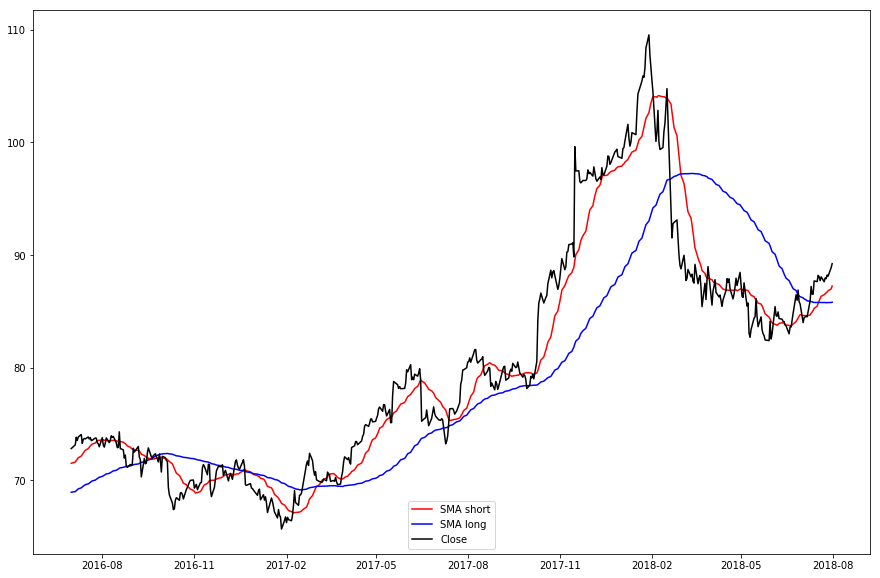

Done simmulating
5.0%
*****************************
Note: Loaded persisted time series data
Note: Loaded persisted time series data
*****************************
Simmulating 524 days for WBA


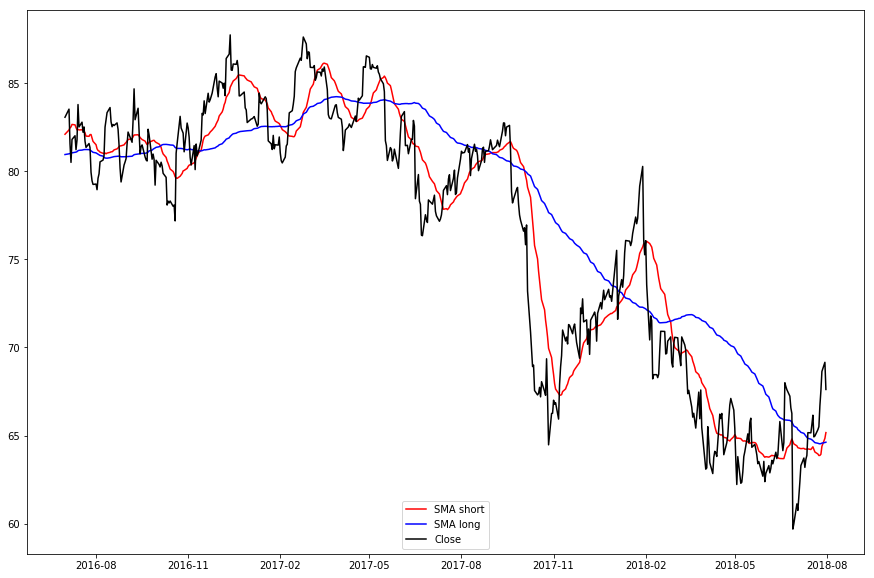

Done simmulating
-19.0%
*****************************


In [302]:

import math
plot=True
verbose=False

def buy(symbol, price, message=None):
    global funds
    global portfolio
    global verbose
    numberOfShares = math.floor(funds/price)
    rest = funds-numberOfShares*price
    funds=rest
    if portfolio.get(symbol,'NA')=='NA':
        if verbose==True:
            print("************")
            if message!=None:
                print(message)
            print("Buying "+str(numberOfShares)+" "+symbol+" at "+str(price)+" totalling "+str(numberOfShares*price))
            print("Funds now: "+str(funds))
        portfolio[symbol]=numberOfShares

def sell(symbol, price, message=None):
    global funds
    global portfolio
    global verbose
    if portfolio.get(symbol,'NA')!='NA':
        funds=funds+portfolio.get(symbol)*price
        numberOfShares=portfolio.get(symbol)
        if verbose==True:
            print("************")
            if message!=None:
                print(message)
            print("Selling "+str(numberOfShares)+" "+symbol+" at "+str(price)+" totalling "+str(numberOfShares*price))
            print("Funds now: "+str(funds))
        portfolio.pop(symbol, None)
        
    
    
#symbols = ['WMT']
symbols = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','XOM','GS','HD','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT','WBA']
portfolio={}
short = 20
long = 90
stopLoss = .04
#del result
for symbol in symbols:
    funds=10000
    fundsBefore=funds
    data = downloadSymbolHistory(symbol,'2999-12-31','not download')
    days = [days for days in getTradingDays(symbol) if days >= '2016-07-01' and days < '2018-08-01']
    daysDate = pd.Series([pd.to_datetime(date).date() for date in days])
    #data = data[data.index.isin(days)]
    print("*****************************") 
    print("Simmulating "+str(len(days))+" days for "+symbol)
    #print("Funds now: "+str(funds))
    
    
    # creating short ans long sma´s
    sma_short = data.Close.rolling(window=short).mean() 
    sma_long  = data.Close.rolling(window=long).mean() 
    
    # Creating prev-values for sma´s
    prev_sma_short = sma_short.shift(1)
    #prev_sma_short.name = 'prev_sma_long'
    
    prev_sma_long = sma_long.shift(1)
    #prev_sma_long.name = 'prev_sma_long'
    #pd.to_numeric(s, errors='coerce')
    
    p=pd.to_numeric(data['Close'], errors='coerce')
    prev_close = p.shift(1)
    
    #result = pd.DataFrame({'Close':data['Close'],
    result = pd.DataFrame({'Close':pd.to_numeric(data['Close'], errors='coerce'),
                           'prev_close':prev_close,
                           #'Date':data['Date'],
                           'sma_short':sma_short,
                           'prev_sma_short':prev_sma_short,
                           'sma_long':sma_long,
                           'prev_sma_long':prev_sma_long}).dropna(axis=0)
    result = result[result.index.isin(days)]

    for day in days:
        v = result.loc[day,]
        if (v.Close-v.prev_close)/v.prev_close < -stopLoss:
            sell(symbol, v.Close, "StopLoss !")
        elif (v.sma_short > v.sma_long) & (v.prev_sma_short < v.prev_sma_long):
            buy(symbol, v.Close)
            
        elif (v.sma_short < v.sma_long) & (v.prev_sma_short > v.prev_sma_long):
            #print(str(day)+": Sell-signal")
            sell(symbol, v.Close)
    
    if plot==True:
        f=plt.figure(figsize=(15,10))
        ax = f.add_subplot(111)
        ax.plot(daysDate, result.sma_short, label="SMA short", color="red")
        ax.plot(daysDate, result.sma_long,  label="SMA long", color="blue")
        #ax.plot(daysDate, pd.to_numeric(result.Close, errors='coerce'), color="black")
        ax.plot(daysDate, result.Close, color="black")
        ax.legend(loc='lower center')
        #ax.yaxis.set_ticks(np.arange(100, 400, 50))
        plt.show()
        #result['Date'] = result.index
        #result.plot()
    if portfolio.get(symbol) != None:
        v = result.iloc[-1]
        sell(symbol,v.Close)
    print("Done simmulating")
    print(str(round((funds-fundsBefore)/fundsBefore*100))+"%")
    print("*****************************")

#result[['Close','sma_long','sma_short']].plot(title="Rolling avgs")
#plt.gcf().set_size_inches(12,8)
#plt.show()
#result.dtypes